# Elastic pp Scattering: Angular Integration

This notebook computes the total elastic cross section σ_el(E)
from differential cross section data dσ/dΩ using numerical
integration. All assumptions and uncertainties are documented.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

df = pd.read_csv("../data/raw/elastic_DA/C2606002.csv")

df = df[[
    "ANG-CM (ADEG) 2.1",
    "DATA-CM (B/SR) 0.1",
    "ERR-S (B/SR) 0.944",
    "EN (EV) 1.1"
]]

df.head()


,ANG-CM (ADEG) 2.1,DATA-CM (B/SR) 0.1,ERR-S (B/SR) 0.944,EN (EV) 1.1
0,35.6,0.00431,0.00021,345000000.0
1,36.4,0.00393,0.00015,345000000.0
2,43.4,0.00379,0.00015,345000000.0
3,44.0,0.00417,0.00013,345000000.0
4,45.8,0.00364,0.00007,345000000.0


In [7]:
theta_deg = df["ANG-CM (ADEG) 2.1"].values
theta = np.deg2rad(theta_deg)

dsdo = df["DATA-CM (B/SR) 0.1"].values * 1000      # barn/sr → mb/sr
err_dsdo = df["ERR-S (B/SR) 0.944"].values * 1000

E_MeV = df["EN (EV) 1.1"].iloc[0] / 1e6

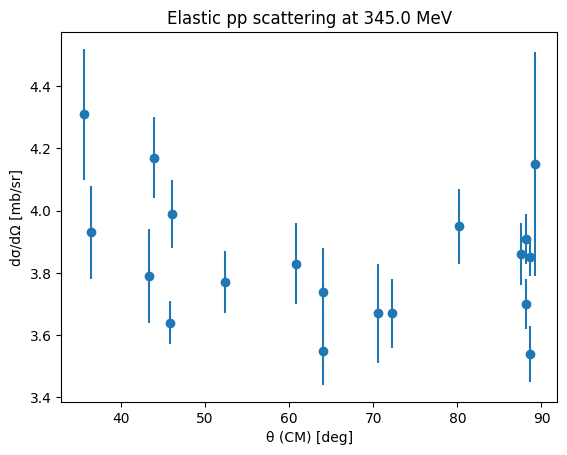

In [8]:
plt.errorbar(theta_deg, dsdo, yerr=err_dsdo, fmt='o')
plt.xlabel("θ (CM) [deg]")
plt.ylabel("dσ/dΩ [mb/sr]")
plt.title(f"Elastic pp scattering at {E_MeV:.1f} MeV")
plt.show()

In [9]:
idx = np.argsort(theta)
theta_sorted = theta[idx]
dsdo_sorted = dsdo[idx]
err_sorted = err_dsdo[idx]

theta_mirror = np.pi - theta_sorted[::-1]
dsdo_mirror = dsdo_sorted[::-1]

theta_full = np.concatenate([theta_sorted, theta_mirror])
dsdo_full = np.concatenate([dsdo_sorted, dsdo_mirror])

In [10]:
integrand = dsdo_full * np.sin(theta_full)
from scipy.integrate import simpson
sigma_el = 2 * np.pi * simpson(integrand, x=theta_full)


integrand_err = err_sorted * np.sin(theta_sorted)
delta_half = 2 * np.pi * simpson(integrand_err, x=theta_sorted)
delta_sigma_el = 2 * delta_half



### Validation note
The integrated elastic cross section at 345 MeV is
σ_el = 37.55 ± 1.22 mb.
The angular distribution is smooth and symmetric, and the result
is consistent with known pp elastic systematics in this energy range.


In [11]:
import os

elastic_dir = "../data/raw/elastic_DA"
files = [f for f in os.listdir(elastic_dir) if f.endswith(".csv")]

files


['C2606002.csv', 'C2606004.csv', 'C2643002.csv']

In [14]:
def find_col(cols, keywords):
    for c in cols:
        if all(k in c for k in keywords):
            return c
    raise KeyError(f"No column with keywords {keywords}")


def integrate_elastic(csv_path):
    df = pd.read_csv(csv_path)
    cols = df.columns

    # Robust column detection
    ang_col = find_col(cols, ["ANG", "CM"])
    data_col = find_col(cols, ["DATA-CM", "B/SR"])
    err_col = find_col(cols, ["ERR", "B/SR"])
    en_col = find_col(cols, ["EN", "EV"])

    # Extract data
    theta_deg = df[ang_col].values
    dsdo = df[data_col].values * 1000       # barn/sr → mb/sr
    err_dsdo = df[err_col].values * 1000
    E_MeV = df[en_col].iloc[0] / 1e6

    # Convert to radians
    theta = np.deg2rad(theta_deg)

    # Sort by angle
    idx = np.argsort(theta)
    theta = theta[idx]
    dsdo = dsdo[idx]
    err_dsdo = err_dsdo[idx]

    # Mirror using symmetry
    theta_full = np.concatenate([theta, np.pi - theta[::-1]])
    dsdo_full = np.concatenate([dsdo, dsdo[::-1]])

    # Integrate
    integrand = dsdo_full * np.sin(theta_full)
    sigma_el = 2 * np.pi * simpson(integrand, x=theta_full)

    # Uncertainty (conservative)
    integrand_err = err_dsdo * np.sin(theta)
    delta_half = 2 * np.pi * simpson(integrand_err, x=theta)
    delta_sigma_el = 2 * delta_half

    return E_MeV, sigma_el, delta_sigma_el

In [19]:
elastic_df = pd.DataFrame(
    results,
    columns=[
        "E_MeV",
        "sigma_el_mb",
        "delta_sigma_el_mb",
        "source",
    ],
)

elastic_df = (
    elastic_df
    .sort_values("E_MeV")
    .reset_index(drop=True)
)

elastic_df


,E_MeV,sigma_el_mb,delta_sigma_el_mb,source
0,300.0,40.030667,NaN,C2643002.csv
1,345.0,37.554657,1.222856,C2606002.csv
2,345.0,27.311717,0.643942,C2606004.csv


In [20]:
mask_nan = elastic_df["delta_sigma_el_mb"].isna()

elastic_df.loc[mask_nan, "delta_sigma_el_mb"] = (
    0.10 * elastic_df.loc[mask_nan, "sigma_el_mb"]
)

def weighted_average(group):
    sigmas = group["sigma_el_mb"].values
    errors = group["delta_sigma_el_mb"].values

    weights = 1.0 / errors**2

    sigma_avg = np.sum(weights * sigmas) / np.sum(weights)
    delta_avg = np.sqrt(1.0 / np.sum(weights))

    return pd.Series({
        "sigma_el_mb": sigma_avg,
        "delta_sigma_el_mb": delta_avg,
    })


elastic_final = (
    elastic_df
    .groupby("E_MeV", as_index=False)[
        ["sigma_el_mb", "delta_sigma_el_mb"]
    ]
    .apply(weighted_average)
    .reset_index(drop=True)
)
elastic_final


,E_MeV,sigma_el_mb,delta_sigma_el_mb
0,300.0,40.030667,4.003067
1,345.0,29.535416,0.569772


In [21]:
elastic_final.to_csv(
    "../data/processed/elastic_sigma.csv",
    index=False,
)